In [1]:
%matplotlib inline
import pandas as pd
import uproot
import awkward
import matplotlib.pyplot as plt
import numpy as np
import glob
from matplotlib.colors import LogNorm
import uproot_methods
from tqdm.auto import tqdm
import time
import re

from utils import (
    set_plotting_style, get_chunking, make_df, hist2d_dask, query_dis,
    dataframe_to_ttree, ttree_to_dataframe
)
import utils

from dask.distributed import Client
import dask.dataframe as dd
import dask.array as da
from dask import delayed
from yahist import Hist1D, Hist2D

from daskucsd.condor_utils import make_htcondor_cluster

from utils import hacky_query_eval as hqe
import subprocess
import json
import requests
import re

In [2]:
set_plotting_style()

In [3]:
df_wpt = pd.read_csv("../theory/btophi/weights_shapeOnly_2.8.txt", sep=" ", skiprows=1, names=["pt","central","down","up","junk"])

hists_wpt = dict()
for which in ["central","up","down"]:
    h = Hist1D.from_bincounts(df_wpt[which].values, bins=np.arange(101), errors=0.*df_wpt[which].values)
    h = Hist1D(h.restrict(0,30), label=which)
    hists_wpt[which] = h
    
blocks = open("../theory/btophi/filter_efficiency_FONLL_shape.txt").read().split("\n\n")
data = []
for block in blocks:
    lines = block.strip().splitlines()
    d = {}
    for line in lines:
        parts = line.split()
        d["mass"] = float(parts[2])
        d[parts[5]] = float(parts[9])/100.
    data.append(d)
df_filteff = pd.DataFrame(data)

# FONLL pt(B)>5 GeV abd(eta)<2.8:
# sigma = 1.33e+08 + 5.42e+07 - 4.05e+07 pb
sigma_fonll_central = 1.33e8 # pb
sigma_fonll_up = sigma_fonll_central + 5.42e7 # pb
sigma_fonll_down = sigma_fonll_central - 4.05e7 # pb


def get_acceptance_btophi(mass, fnames):
    df_gen = pd.concat([uproot.open(fname)["btophitree"].pandas.df() for fname in fnames])
    df_gen = df_gen[df_gen.eval("BToPhi_nphi==1 and BToPhi_bmesonpt>5 and abs(BToPhi_bmesoneta)<2.8")].reset_index(drop=True)
    df_gen = df_gen.copy()
    epsgen_central = df_filteff[np.isclose(df_filteff["mass"],mass)]["central"].values[0]

    df_reco = pd.concat(
        [uproot.open(fname)["Events"].pandas.df(["pass_all", "mass", "lxy", "BToPhi_nphi", "BToPhi_bmesonpt", "BToPhi_bmesoneta"])
         for fname in fnames]
    )
    df_reco = df_reco[df_reco.eval("BToPhi_nphi==1 and BToPhi_bmesonpt>5 and abs(BToPhi_bmesoneta)<2.8")].reset_index(drop=True)
    df_reco = df_reco[df_reco.eval("pass_all")]
    df_reco = df_reco.copy()

    for which in ["central", "up", "down"]:
        df_gen[f"wpt_{which}"] = hists_wpt[which].lookup(df_gen["BToPhi_bmesonpt"])
        df_reco[f"wpt_{which}"] = hists_wpt[which].lookup(df_reco["BToPhi_bmesonpt"])

    acceptance_central = df_reco["wpt_central"].sum()/df_gen["wpt_central"].sum()
    acceptance_wrt_unfilt = acceptance_central*epsgen_central
    return acceptance_wrt_unfilt

# Note that to get BR(b->B->phi), you'd do
#     br_central = 0.5*neventsUL / (acceptance_wrt_unfilt*lumi_pb*sigma_fonll_central)

In [105]:
# to calculate 1-efficiency uncertainty in each lxy bin (denom is HLT*L1 and numer is full analysis cuts)
def get_eff_lookup(fnames):
    lxyedges = np.array([0.0, 0.2, 1.0, 2.4, 3.1, 7.0, 11.])
    df = pd.concat([uproot.open(fname)["Events"].pandas.df(branches=["pass_l1","pass_all","lxy"]) for fname in fnames])
    numer = Hist1D(df[df.eval("pass_all and pass_l1")]["lxy"], bins=lxyedges)
    denom = Hist1D(df[df.eval("pass_l1")]["lxy"], bins=lxyedges)
    heff = numer.divide(denom)
    return heff

In [106]:
dirnames_hzd = glob.glob("/hadoop/cms/store/user/namin/ProjectMetis/HToZdZdTo2Mu2X_params_m*_ctau*mm_BABY_vtestfine2/")
dirnames_btophi = glob.glob("/hadoop/cms/store/user/namin/ProjectMetis/BToPhi_params_m*_ctau*mm_BABY_vtestfine2/")

In [116]:
def make_dfs(dirnames):
    dfs = dict()
    is_btophi = False
    for dirname in tqdm(dirnames):
        if "BToPhi" in dirname:
            is_btophi = True
            m = re.match(".*mphi([0-9p]+)_ctau([0-9]+).*", dirname)
            groups = list(m.groups())
            groups[0] = groups[0].replace("p",".")
        else:
            m = re.match(".*mzd([0-9\.]+)_ctau([0-9]+).*", dirname.replace("p","."))
            groups = list(m.groups())
        mass, ctau = map(float,groups)
        if is_btophi and mass > 5.: continue
        if is_btophi and mass < 0.3: continue
        fnames = glob.glob(f"{dirname}/*.root")
        if not len(fnames): continue
        tmp = []
        nevents_processed = 0
        for fname in fnames:
            f = uproot.open(fname)
            t = f["Events"]
            sel = t["pass_all"].array()
            colnames = ["mass","lxy","ctau","Muon2_pt",]
            nevents_processed += int(f["nevents_processed"].value)
            if is_btophi:
                colnames += ["BToPhi_nphi", "BToPhi_bmesonpt", "BToPhi_bmesoneta"]
            else:
                colnames += ["HZdZd_nzd"]
            d = t.arrays(colnames,outputtype=dict,namedecode="ascii")
            df = pd.DataFrame({k:v[sel] for k,v in d.items()})
            df = df.rename({"ctau":"ct"},axis=1)
            df["gen_mass"] = mass
            df["gen_ctau"] = ctau
            if is_btophi:
                df = df[df.eval("BToPhi_nphi==1 and BToPhi_bmesonpt>5 and abs(BToPhi_bmesoneta)<2.8")]
            tmp.append(df)
        df = pd.concat(tmp).reset_index(drop=True)
        df["oneminuseff"] = np.abs(1. - get_eff_lookup(fnames).lookup(df["lxy"]))
        if is_btophi:
            acceptance = get_acceptance_btophi(mass, fnames)
            df["acceptance"] = acceptance
            df["xsec_pb"] = sigma_fonll_central
            df["xsec_pb_down"] = sigma_fonll_down
            df["xsec_pb_up"] = sigma_fonll_up
            df = df.drop(["BToPhi_nphi","BToPhi_bmesonpt","BToPhi_bmesoneta"], axis=1)
        else:
            nevents_input = pd.concat(
                [uproot.open(fname)["hzdzdtree"].pandas.df()
                for fname in fnames]
            ).eval("HZdZd_nzd == 1").sum()
            df["nevents_input"] = nevents_input
            df = df.drop(["HZdZd_nzd"], axis=1)
        df.attrs["nevents_processed"] = nevents_processed
        dfs[(mass,ctau)] = df.reset_index(drop=True)
    print("{}M input events".format(sum(x.attrs["nevents_processed"] for x in dfs.values())/1e6))
    return dfs
    

dfs_btophi = make_dfs(dirnames_btophi)
dfs_hzd = make_dfs(dirnames_hzd)

<ipython-input-75-2f3b431dc867>:46: RuntimeWarning: invalid value encountered in double_scalars
  acceptance_central = df_reco["wpt_central"].sum()/df_gen["wpt_central"].sum()



1.666008M input events



15.755M input events


In [117]:
dfs_btophi[(2.0,10.)].head()

,mass,lxy,ct,Muon2_pt,gen_mass,gen_ctau,oneminuseff,acceptance,xsec_pb,xsec_pb_down,xsec_pb_up
0,2.034944,7.799437,1.710057,3.399138,2.0,10.0,0.280702,0.004822,133000000.0,92500000.0,187200000.0
1,1.967048,4.226967,0.793838,4.223173,2.0,10.0,0.321586,0.004822,133000000.0,92500000.0,187200000.0
2,1.940457,1.607117,0.224978,6.752897,2.0,10.0,0.413381,0.004822,133000000.0,92500000.0,187200000.0
3,1.981589,10.437196,0.917277,11.091686,2.0,10.0,0.280702,0.004822,133000000.0,92500000.0,187200000.0
4,1.802204,7.543761,1.016428,5.327916,2.0,10.0,0.280702,0.004822,133000000.0,92500000.0,187200000.0


In [118]:
pd.concat([df.head(1) for df in dfs_btophi.values()]).head()

,mass,lxy,ct,Muon2_pt,gen_mass,gen_ctau,oneminuseff,acceptance,xsec_pb,xsec_pb_down,xsec_pb_up
0,0.301637,4.961868,0.141549,4.570776,0.3,100.0,0.250000,0.000005,133000000.0,92500000.0,187200000.0
0,0.299688,10.100673,0.221661,5.305088,0.3,10.0,0.272727,0.000098,133000000.0,92500000.0,187200000.0
0,0.302050,5.442962,0.173251,3.954314,0.3,1.0,0.460227,0.000454,133000000.0,92500000.0,187200000.0
0,0.398773,4.842249,0.203149,4.197419,0.4,100.0,0.333333,0.000093,133000000.0,92500000.0,187200000.0
0,0.395599,1.765672,0.058823,4.399837,0.4,10.0,0.373239,0.000746,133000000.0,92500000.0,187200000.0


In [119]:
import numba

@numba.vectorize()
@numba.njit()
def get_trigger_sf_or_error(lxy, mu2pt, error=False):
    if (mu2pt > 30.0): mu2pt = 29.9
    if (lxy < 0.25):
        if ((mu2pt >= 3.0) and (mu2pt < 5.0)): return (0.034 if error else 1.031)
        if ((mu2pt >= 5.0) and (mu2pt < 10.0)): return (0.040 if error else 0.963)
        if ((mu2pt >= 10.0) and (mu2pt < 15.0)): return (0.041 if error else 0.975)
        if ((mu2pt >= 15.0) and (mu2pt < 30.0)): return (0.080 if error else 0.945)
    if ((lxy < 1.0) and (lxy > 0.25)):
        if ((mu2pt >= 3.0) and (mu2pt < 5.0)): return (0.199 if error else 1.192)
        if ((mu2pt >= 5.0) and (mu2pt < 10.0)): return (0.027 if error else 0.990)
        if ((mu2pt >= 10.0) and (mu2pt < 15.0)): return (0.043 if error else 0.988)
        if ((mu2pt >= 15.0) and (mu2pt < 30.0)): return (0.085 if error else 0.937)
    if (lxy >= 1.0):
        if ((lxy >= 1.0) and (lxy < 2.4)): return (0.127 if error else 1.000)
        if ((lxy >= 2.4) and (lxy < 3.1)): return (0.248 if error else 1.000)
        if ((lxy >= 3.1) and (lxy < 11.0)): return (0.314 if error else 1.000)
    return (0. if error else 1.)

In [120]:
df_btophi = (pd.concat(dfs_btophi.values())
    .rename({"gen_mass":"sample_mass","gen_ctau":"sample_ctau","acceptance":"acceptance","Muon2_pt":"mu2pt"},axis=1)
    .sort_values(["sample_mass","sample_ctau"])
    .reset_index(drop=True)
    .assign(
     trigsf=lambda x: get_trigger_sf_or_error(x["lxy"].values,x["mu2pt"].values,False),
     trigsf_error=lambda x: get_trigger_sf_or_error(x["lxy"].values,x["mu2pt"].values,True),
    )
    .drop("mu2pt",axis=1)
)

utils.dataframe_to_ttree(df_btophi, "btophi_mass_ctau_scan.root", "t")
!cp "btophi_mass_ctau_scan.root" ~/public_html/dump/forHardik/scan/
print("http://uaf-10.t2.ucsd.edu/~namin/dump/forHardik/scan/btophi_mass_ctau_scan.root")
!ls -lrth btophi_mass_ctau_scan.root
df_btophi


http://uaf-10.t2.ucsd.edu/~namin/dump/forHardik/scan/btophi_mass_ctau_scan.root
-rw-rw-r--+ 1 namin namin 607K Nov 18  2020 btophi_mass_ctau_scan.root


,mass,lxy,ct,sample_mass,sample_ctau,oneminuseff,acceptance,xsec_pb,xsec_pb_down,xsec_pb_up,trigsf,trigsf_error
0,0.302050,5.442962,0.173251,0.3,1.0,0.460227,0.000454,133000000.0,92500000.0,187200000.0,1.000,0.314
1,0.296522,4.974435,0.147871,0.3,1.0,0.460227,0.000454,133000000.0,92500000.0,187200000.0,1.000,0.314
2,0.306639,4.056095,0.153807,0.3,1.0,0.460227,0.000454,133000000.0,92500000.0,187200000.0,1.000,0.314
3,0.303650,3.091329,0.064956,0.3,1.0,0.523810,0.000454,133000000.0,92500000.0,187200000.0,1.000,0.248
4,0.309887,2.237169,0.099079,0.3,1.0,0.468354,0.000454,133000000.0,92500000.0,187200000.0,1.000,0.127
...,...,...,...,...,...,...,...,...,...,...,...,...
32639,4.748988,3.807389,2.131745,5.0,100.0,0.000000,0.003182,133000000.0,92500000.0,187200000.0,1.000,0.314
32640,4.641507,3.695541,0.918312,5.0,100.0,0.000000,0.003182,133000000.0,92500000.0,187200000.0,1.000,0.314
32641,4.935683,1.693293,0.831335,5.0,100.0,0.000000,0.003182,133000000.0,92500000.0,187200000.0,1.000,0.127
32642,4.696154,0.623504,0.208003,5.0,100.0,0.500000,0.003182,133000000.0,92500000.0,187200000.0,1.192,0.199


In [121]:
dftheory = pd.read_csv("../theory/hzd/hzd.csv")
dftheory = dftheory.rename({"br_zdtosm":"br_zdtomumu"},axis=1)
dftheory["sample_mass"] = dftheory["mass"]*1e-3

In [122]:
df_hzd = (pd.concat(dfs_hzd.values())
    .rename({"gen_mass":"sample_mass","gen_ctau":"sample_ctau","Muon2_pt":"mu2pt"},axis=1)
    .sort_values(["sample_mass","sample_ctau"])
    .reset_index(drop=True)
    .assign(
     trigsf=lambda x: get_trigger_sf_or_error(x["lxy"].values,x["mu2pt"].values,False),
     trigsf_error=lambda x: get_trigger_sf_or_error(x["lxy"].values,x["mu2pt"].values,True),
    )
    .drop("mu2pt",axis=1)
)

# merge in BR(zdtomumu)
df_hzd = df_hzd.merge(dftheory[["sample_mass","br_zdtomumu"]], on="sample_mass")

utils.dataframe_to_ttree(df_hzd, "hzd_mass_ctau_scan.root", "t")
!cp "hzd_mass_ctau_scan.root" ~/public_html/dump/forHardik/scan/
print("http://uaf-10.t2.ucsd.edu/~namin/dump/forHardik/scan/hzd_mass_ctau_scan.root")
!ls -lrth hzd_mass_ctau_scan.root
df_hzd


http://uaf-10.t2.ucsd.edu/~namin/dump/forHardik/scan/hzd_mass_ctau_scan.root
-rw-rw-r--+ 1 namin namin 8.7M Nov 18  2020 hzd_mass_ctau_scan.root


,mass,lxy,ct,sample_mass,sample_ctau,oneminuseff,nevents_input,trigsf,trigsf_error,br_zdtomumu
0,0.299903,3.978894,0.112509,0.3,1.0,0.555556,352416,1.000,0.314,0.469274
1,0.298453,4.550060,0.121147,0.3,1.0,0.555556,352416,1.000,0.314,0.469274
2,0.320859,2.622097,0.043848,0.3,1.0,0.666667,352416,1.000,0.248,0.469274
3,3.111270,0.103108,0.031390,0.3,1.0,0.998090,352416,0.963,0.040,0.469274
4,0.299300,5.300125,0.122736,0.3,1.0,0.555556,352416,1.000,0.314,0.469274
...,...,...,...,...,...,...,...,...,...,...
504004,25.068611,5.430089,3.220753,25.0,1000.0,0.335366,25549,1.000,0.314,0.141820
504005,24.637911,8.725270,3.069813,25.0,1000.0,0.211111,25549,1.000,0.314,0.141820
504006,23.604834,5.715425,2.664203,25.0,1000.0,0.335366,25549,1.000,0.314,0.141820
504007,24.156324,7.910277,2.872829,25.0,1000.0,0.211111,25549,1.000,0.314,0.141820


In [123]:
table_css = """
body {
    margin: 0;
    font-family: Helvetica;
    padding: 1%;
}
table.dataframe {
    border-collapse: collapse;
    border: none;
}
table.dataframe tr {
    border: none;
}
table.dataframe td, table.dataframe th {
    margin: 0;
    border: 1px solid white;
    padding-left: 0.25em;
    padding-right: 0.25em;
}
table.dataframe th:not(:empty) {
    background-color: #eee;
    text-align: left;
    font-weight: normal;
}
table.dataframe tr:nth-child(2) th:empty {
    border-left: none;
    border-right: 1px dashed #888;
}
table.dataframe td {
    border: 2px solid #ccc;
}
"""

from IPython.display import HTML
buff = ""
buff += "<style>\n"
buff += table_css
buff += "</style>\n"
buff += "Events pass all selections and have exactly 1 LLP at gen-level<br>"
buff += "<h4>Common branches:</h4>"
buff += "<ul>"
buff += "    <li><b>mass, lxy</b>: reco dimuon mass, lxy</li>"
buff += "    <li><b>ct</b>: gen. event-level ct (for ctau reweighting)</li>"
buff += "    <li><b>sample_mass/sample_ctau</b>: gen. mass, ctau</li>"
buff += "    <li><b>nevents_input</b>: number of generated events for acceptance calculation purposes</li>"
buff += "    <li><b>trigsf, trigsf_error</b>: trigger SF and error</li>"
buff += "    <li><b>oneminuseff</b>: 1-efficiency (efficiency is of full analysis cuts wrt HLT && L1, in each bin of lxy; used for uncertainty)</li>"
buff += "</ul>"
buff += "<br>"
buff += "<h4>HZdZd ntuple:</h4>"
buff += "<ul>"
buff += "    <li><b>br_zdtomumu</b>: BR(Zd->mumu) (depends on <b>sample_mass</b>)</li>"
buff += "</ul>"
buff += df_hzd.head().to_html()
buff += "<br>"
buff += "<h4>BToPhi ntuple:</h4>"
buff += "<ul>"
buff += "    <li><b>acceptance</b>: acceptance*eff</li>"
buff += "    <li><b>xsec_pb (xsec_pb_up, xsec_pb_down)</b>: FONLL cross-section in pb (+ upper and lower variations)</li>"
buff += "</ul>"
buff += "<b>NOTE</b>: To calculate BR(b->B->phi), do BR = 0.5*neventsUL / (acceptance*lumi_pb*xsec_pb)."
buff += "For mass=2GeV, ctau=10mm, BR should be roughly 2e-9."
buff += "<br>"
buff += "<br>"
buff += df_btophi.head().to_html()


In [124]:
fname = "/home/users/namin/public_html/dump/forHardik/scan/README.html"
with open(fname, "w") as fh:
    fh.write(buff)
print("http://uaf-10.t2.ucsd.edu/~namin/dump/forHardik/scan/README.html")

http://uaf-10.t2.ucsd.edu/~namin/dump/forHardik/scan/README.html


sample_ctau
1.0      AxesSubplot(0.125,0.125;0.835x0.755)
10.0     AxesSubplot(0.125,0.125;0.835x0.755)
100.0    AxesSubplot(0.125,0.125;0.835x0.755)
Name: acceptance, dtype: object

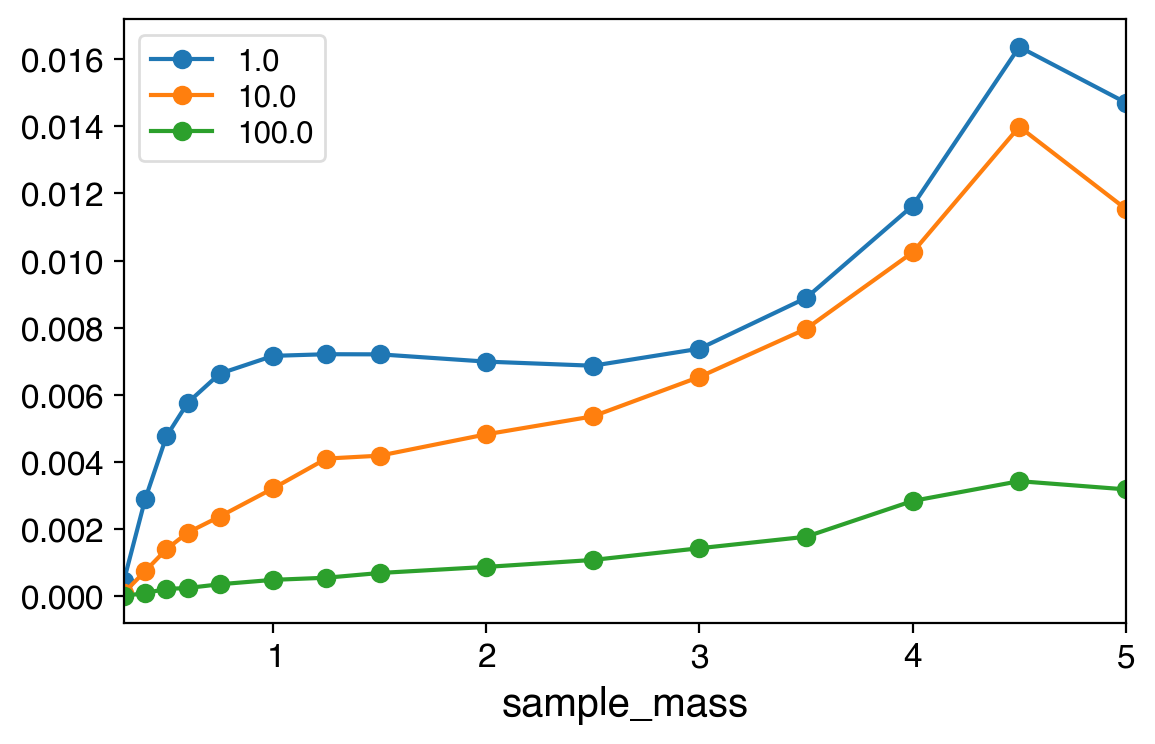

In [125]:
(df_btophi
 .groupby(["sample_mass","sample_ctau"])
 .head(1)
 .set_index("sample_mass")
 .groupby("sample_ctau")
 ["acceptance"].plot(marker="o", legend=True)
)

Text(0.5, 0, 'lxy (cm)')

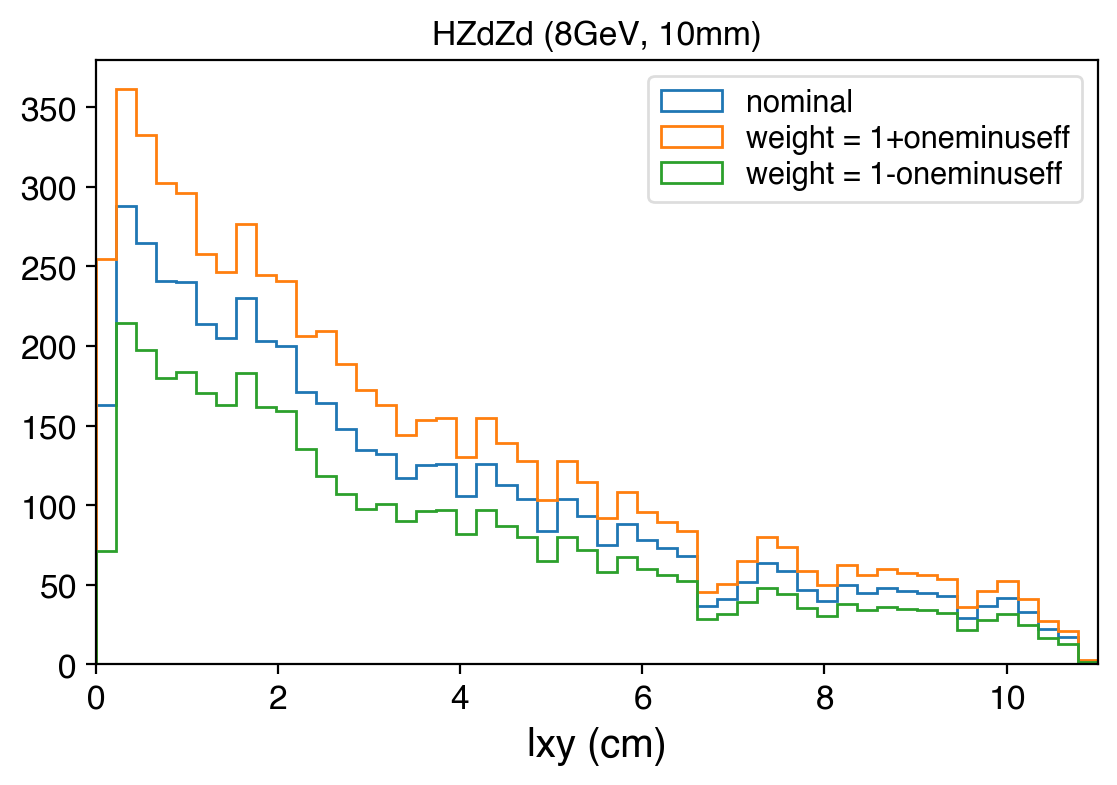

In [130]:
df = df_hzd.query("sample_mass == 8 and sample_ctau == 10")
bins = "50,0,11"
fig, ax = plt.subplots()
ax.set_title("HZdZd (8GeV, 10mm)")
Hist1D(df["lxy"], bins=bins).plot(histtype="step", label="nominal")
Hist1D(df["lxy"], bins=bins, weights=1 + df["oneminuseff"]).plot(histtype="step", label="weight = 1+oneminuseff")
Hist1D(df["lxy"], bins=bins, weights=1 - df["oneminuseff"]).plot(histtype="step", label="weight = 1-oneminuseff")
ax.set_xlabel("lxy (cm)")